# Deep interpolator tests and whatnot

The idea is to have a neural network that can predict the pen movement a few moments ahead, so that it compensates for the lag created by interpolation.
For a dataset it would be nice to have raw recordings straight from the OpenTabletDriver, but that path exporter plugin I made have been abandoned for a while, and gathering data from people would be a pain.
Instead, I'll first use my osu replays, they are not perfect (60hz vs 133 on most wacoms or 200 on pro models), but that data is gonna be interpolated anyway, so it's not a big deal.

## What the input data will look like

Replays don't have a uniform sampling rate, so I'll have to interpolate them and sample from that.
Frequency can be anything, I think 125hz is a good starting point.
Interpolation will be a non-uniform Catmull-Rom spline, sampled with a Barry Goldman algorithm, knots based on the timestamps of the replay.

The network will be fed with a sequence of speed vectors, so that it's invariant to position.
Rotation and scale invariance will be achieved by augmenting the data with random rotations and scales.

Output will be the next speed vector in a sequence.

In [1]:
import os
import itertools
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from osrparse import Replay, ReplayEvent, ReplayEventOsu, GameMode
from typing import List, Tuple, Dict, Any, Optional, Union, Iterable, Callable
from tqdm import tqdm
# from multiprocessing import Pool


In [ ]:
# Read an example replay

with open("Replays/AbstractQbit - BUD VIRGIN LOGIC - x Senritsu -Schlehit Melodie- [Kneel Before Me] (2022-11-12) Osu - Copy.osr", 'br') as f:
    replay = Replay.from_file(f)

replay.replay_data
# Output example:
# [ReplayEventOsu(time_delta=16, x=230.0, y=169.6667, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=0, x=230.3333, y=169.0, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=0, x=232.6667, y=167.3333, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=0, x=234.0, y=167.6667, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=8, x=234.3333, y=167.6667, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=17, x=235.3333, y=166.6667, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=18, x=236.0, y=165.3333, keys=<Key.0: 0>),
#  ReplayEventOsu(time_delta=5, x=236.0, y=165.3333, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=10, x=236.3333, y=164.6667, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=18, x=236.6667, y=163.3333, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=17, x=237.0, y=162.3333, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=16, x=237.6667, y=161.0, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=16, x=238.0, y=160.3333, keys=<Key.K2|M2: 10>),
#  ReplayEventOsu(time_delta=15, x=238.0, y=160.0, keys=<Key.K2|K1|M2|M1: 15>),
#  ReplayEventOsu(time_delta=2, x=238.0, y=160.0, keys=<Key.K2|K1|M2|M1: 15>),
#  ReplayEventOsu(time_delta=11, x=238.0, y=160.0, keys=<Key.K1|M1: 5>),
#  ReplayEventOsu(time_delta=6, x=238.0, y=159.6667, keys=<Key.K1|M1: 5>),
#  ReplayEventOsu(time_delta=16, x=238.3333, y=159.3333, keys=<Key.K1|M1: 5>),
#  ReplayEventOsu(time_delta=18, x=238.3333, y=159.0, keys=<Key.K1|M1: 5>),
#  ...]

(0        16
 1         0
 2         0
 3         0
 4         8
          ..
 15474     6
 15475    17
 15476    17
 15477    16
 15478    11
 Length: 15479, dtype: int64,
 count    15479.000000
 mean        13.812391
 std          4.782727
 min          0.000000
 25%         12.000000
 50%         16.000000
 75%         17.000000
 max         20.000000
 dtype: float64)

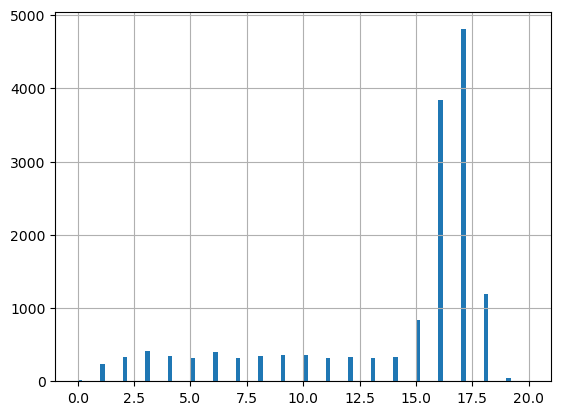

In [3]:
# Extract time deltas into pandas series
time_deltas = pd.Series([event.time_delta for event in replay.replay_data])
time_deltas.hist(bins=100)
time_deltas, time_deltas.describe()

In [4]:
# something = read_replay_data("Replays/AbstractQbit - dj TAKA - quaver [Crescendo] (2021-07-03) Osu.osr")
# something = pd.Series([event.time_delta for event in something])
# something.describe()

In [5]:
def read_replay(filename):
    with open(filename, 'br') as f:
        replay = Replay.from_file(f)
    return replay


def get_replays_from_folder(path, mode: GameMode = GameMode.STD):
    for f in os.listdir(path):
        if not f.endswith(".osr"):
            continue
        replay = read_replay(os.path.join(path, f))
        if replay.mode is mode:
            yield replay

In [6]:
def read_replay_data(filename):
    return read_replay(filename).replay_data


def replay_to_delta_series(replay_data, dropneg = True):
    # Negative time_delta might happen at the start of the replay, probably due to intro skip.
    # Might also happen if offset is changed on the fly, but that's probably rare.
    return pd.Series([event.time_delta for event in replay_data if (event.time_delta > 0 or not dropneg)])


In [7]:
def fix_time_deltas(replay: Iterable[ReplayEventOsu]):
    """
    Filter out negative delta events at the start and replace 0 delta with a 1.
    """
    for event in replay:
        if event.time_delta > 0:
            yield event
        elif event.time_delta == 0:
            yield ReplayEventOsu(time_delta=1, x=event.x, y=event.y, keys=event.keys)


# Turns out that osu! still records events for some time even if there is no position change, so just checking for deltas is not enough.
def collapse_stationary(replay: Iterable[ReplayEventOsu]):
    """
    Collapse all consecutive stationary events and put their time_delta sum into the following event.
    """
    last_x, last_y = 0, 0
    cumulative_delta = 0
    for event in replay:
        if event.x == last_x and event.y == last_y:
            cumulative_delta += event.time_delta
        else:
            yield ReplayEventOsu(
                time_delta=event.time_delta + cumulative_delta,
                x=last_x,
                y=last_y,
                keys=event.keys)
            last_x, last_y = event.x, event.y
            cumulative_delta = 0


def get_stroke_splits(replay: List[ReplayEventOsu], delta_threshold=25):
    """
    Split a replay into strokes using a time delta threshold.
    """
    split_points = [0]
    for i in range(len(replay)):
        if replay[i].time_delta > delta_threshold:
            split_points.append(i)
    split_points.append(len(replay)+1)
    splits = []
    for i in range(len(split_points)-1):
        splits.append(replay[split_points[i]:split_points[i+1]])
    return splits

In [8]:
first_storm_fn = "Replays/AbstractQbit - DECO27 - First Storm -Japanese Version- [Confidence] (2021-08-12) Osu.osr"
first_storm = read_replay_data(first_storm_fn)
first_storm = replay_to_delta_series(first_storm, dropneg=True)
first_storm.describe()

count    15130.000000
mean        13.807138
std          4.795392
min          1.000000
25%         12.000000
50%         16.000000
75%         17.000000
max         22.000000
dtype: float64

In [9]:
# get delta series for the entire folder

folder_path = "Replays/"
# folder_path = "H:/osu!/Data/r/"

files = [folder_path + f for f in os.listdir(folder_path) if f.endswith(".osr")]#[:1000]
deltas = [replay_to_delta_series(collapse_stationary(read_replay_data(f))) for f in tqdm(files)]

# replays = itertools.islice(get_replays_from_folder(folder_path), 1000)
# deltas = [replay_to_delta_series(collapse_stationary(replay.replay_data)) for replay in tqdm(replays)]


100%|██████████| 105/105 [00:10<00:00, 10.02it/s]


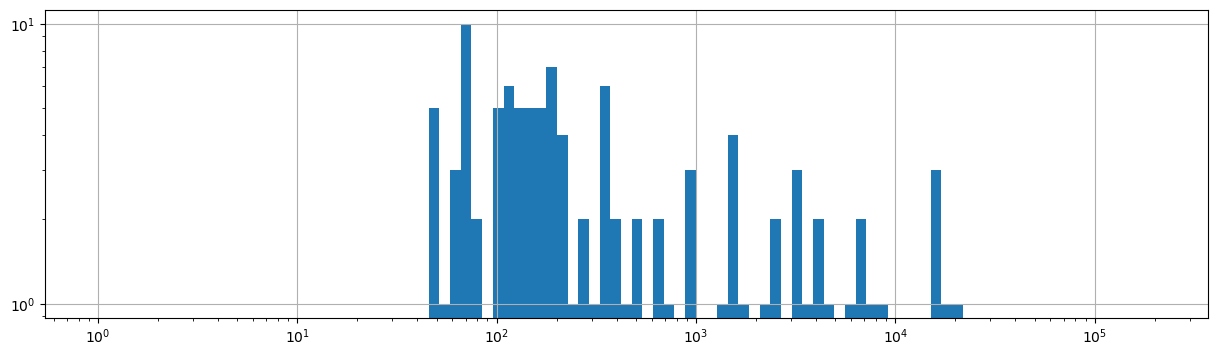

In [10]:
# Get max delta for each replay

maxes = [d.max() for d in deltas]
maxes = pd.Series(maxes)
maxes.hist(bins=np.geomspace(1, 200000, 100), figsize=(15,4))
plt.xscale('log')
plt.yscale('log')
# maxes.describe()

In [11]:
maxes.quantile(np.arange(0, 1.1, 0.1))

0.0       48.0
0.1       67.0
0.2       95.4
0.3      121.6
0.4      162.2
0.5      198.0
0.6      353.8
0.7      605.4
0.8     1649.0
0.9     4301.2
1.0    20190.0
dtype: float64

In [12]:
# concatenate all deltas into one series and plot
all_deltas = pd.concat(deltas)

Text(0, 0.5, 'Count')

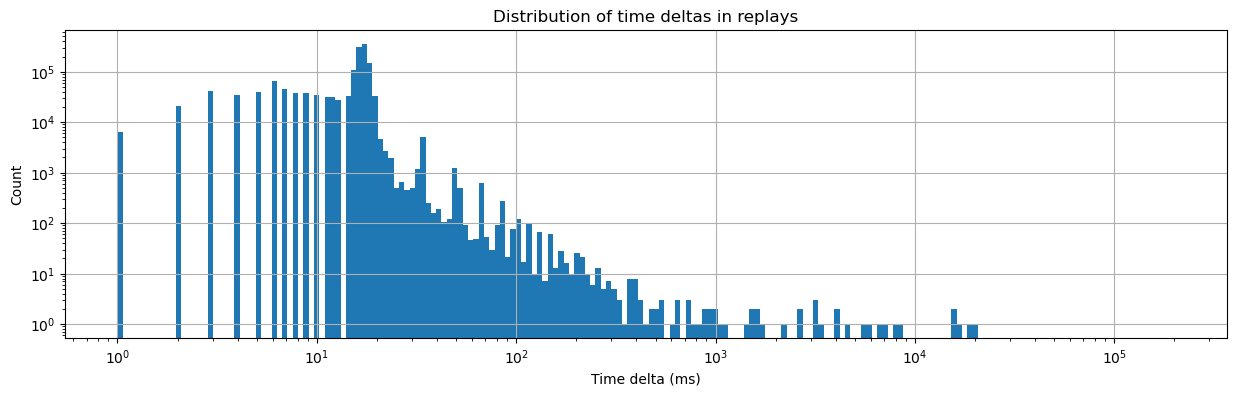

In [13]:
all_deltas.hist(bins=np.geomspace(1, 200000, 200), figsize=(15,4))
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of time deltas in replays")
plt.xlabel("Time delta (ms)")
plt.ylabel("Count")

# all_deltas.describe()

osu! records replays at 60fps, thus 16.67ms is an average delta between frames.

From max deltas across some of my replays, it seems like around 25ms is a good cutoff to separate replays into continuous pen strokes.
Maybe it's a good idea to also check for very abrupt jumps aswell, in case the game was paused or something.

In [14]:
# set the threshold for max delta
threshold = 50

# filter the list of files based on the max delta
files_above_threshold = [files[i] for i in range(len(files)) if maxes[i] > threshold]

# print the list of files
print(*files_above_threshold, sep='\n')


Replays/AbstractQbit - 765 MILLION ALLSTARS - UNION!! [We are all MILLION!!] (2020-11-17) Osu.osr
Replays/AbstractQbit - Alex S. - My Little Pony Intro (Glitch Remix) [TASTE THE RAINBOW!] (2020-10-17) Osu.osr
Replays/AbstractQbit - BUD VIRGIN LOGIC - x Senritsu -Schlehit Melodie- [Kneel Before Me] (2022-11-12) Osu - Copy.osr
Replays/AbstractQbit - BUD VIRGIN LOGIC - x Senritsu -Schlehit Melodie- [Kneel Before Me] (2022-11-12) Osu.osr
Replays/AbstractQbit - Chikamori Kayako - Kigurumi Sungeki [Labyrinth of Steam] (2021-06-05) Osu-1.osr
Replays/AbstractQbit - Chikamori Kayako - Kigurumi Sungeki [Labyrinth of Steam] (2021-06-05) Osu.osr
Replays/AbstractQbit - Chikamori Kayako - Kigurumi Sungeki [Labyrinth of Steam] (2021-07-02) Osu-1.osr
Replays/AbstractQbit - Chikamori Kayako - Kigurumi Sungeki [Labyrinth of Steam] (2021-07-02) Osu.osr
Replays/AbstractQbit - DECO27 - First Storm -Japanese Version- [Confidence] (2021-08-08) Osu.osr
Replays/AbstractQbit - DECO27 - First Storm -Japanese Ver

In [15]:
# split_example = "Replays/AbstractQbit - DECO27 - First Storm -Japanese Version- [Confidence] (2021-11-07) Osu.osr"
# split_example = "H:/osu!/Data/r/b621c3e276a8deebc5ead7b15487bac5-133123027019461359.osr"
split_example = "AbstractQbit - ReoNa - Untitled world [Liberation] (2023-10-09) Osu.osr"
split_example = read_replay_data(split_example)
# split_example = replay_to_series(split_example, dropneg=True)
# split_example.sort_values(ascending=False)[:20]
# split_example.hist(bins=100)
split_example = [replay for replay in collapse_stationary(split_example)]
split_example


[ReplayEventOsu(time_delta=-1671, x=0, y=0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=259.3333, y=183.3333, keys=<Key: 0>),
 ReplayEventOsu(time_delta=18, x=257.0, y=183.6667, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=253.6667, y=184.6667, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=250.6667, y=195.0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=248.3333, y=198.6667, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=247.3333, y=188.0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=18, x=246.6667, y=188.6667, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=232.6667, y=187.0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=233.0, y=186.0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=233.0, y=186.3333, keys=<Key: 0>),
 ReplayEventOsu(time_delta=16, x=232.6667, y=186.3333, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=231.6667, y=187.0, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=230.0, y=186.3333, keys=<Key: 0>),
 ReplayEventOsu(time_delta=17, x=227.0, y=18

In [16]:
sample = np.array([[event.x, event.y] for event in split_example])
deltas = np.array([event.time_delta for event in split_example])
deltas[0] = 0
timings = np.cumsum(deltas)
replay = np.hstack((timings.reshape(-1, 1), sample))
# replay = np.hstack((deltas.reshape(-1, 1), positions))
replay

# mask = np.all(np.diff(replay, axis=0)[:, [1, 2]] == [0, 0], axis=1)
# mask

array([[   0.    ,    0.    ,    0.    ],
       [  16.    ,  259.3333,  183.3333],
       [  34.    ,  257.    ,  183.6667],
       [  50.    ,  253.6667,  184.6667],
       [  66.    ,  250.6667,  195.    ],
       [  83.    ,  248.3333,  198.6667],
       [ 100.    ,  247.3333,  188.    ],
       [ 118.    ,  246.6667,  188.6667],
       [ 134.    ,  232.6667,  187.    ],
       [ 150.    ,  233.    ,  186.    ],
       [ 167.    ,  233.    ,  186.3333],
       [ 183.    ,  232.6667,  186.3333],
       [ 200.    ,  231.6667,  187.    ],
       [ 217.    ,  230.    ,  186.3333],
       [ 234.    ,  227.    ,  183.6667],
       [ 251.    ,  224.6667,  182.    ],
       [ 267.    ,  223.6667,  181.6667],
       [ 284.    ,  223.    ,  181.6667],
       [ 333.    ,  222.3333,  181.3333],
       [ 350.    ,  222.6667,  181.    ],
       [ 366.    ,  224.    ,  181.    ],
       [ 383.    ,  225.    ,  180.6667],
       [ 401.    ,  226.3333,  181.    ],
       [ 417.    ,  227.3333,  181

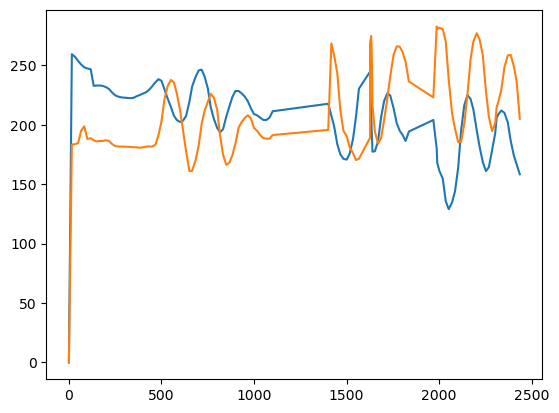

In [17]:
plt.plot(replay[:, 0], replay[:, [1, 2]])

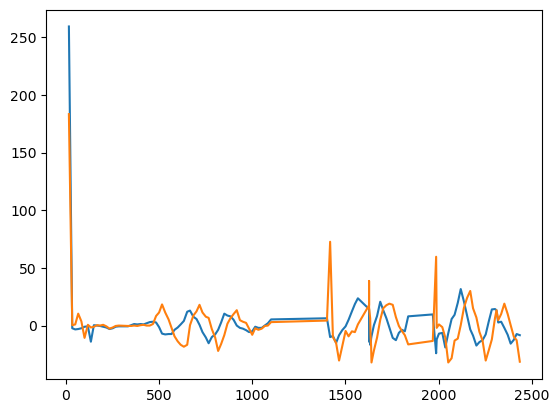

In [18]:
velocities = np.diff(sample, axis=0) #/ np.diff(timings + 0.001)[:, None]
plt.plot(timings[1:], velocities)

## Spline sampling

In [19]:
split_example = "AbstractQbit - ReoNa - Untitled world [Liberation] (2023-10-09) Osu.osr"
# split_example = "Replays/AbstractQbit - DECO27 - First Storm -Japanese Version- [Confidence] (2021-11-07) Osu.osr"
split_example = read_replay_data(split_example)
split_example = fix_time_deltas(split_example)
split_example = collapse_stationary(split_example)
split_example = list(split_example)
split_example = get_stroke_splits(split_example, delta_threshold=50)
split_example

[[ReplayEventOsu(time_delta=16, x=0, y=0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=18, x=257.0, y=183.6667, keys=<Key: 0>),
  ReplayEventOsu(time_delta=16, x=253.6667, y=184.6667, keys=<Key: 0>),
  ReplayEventOsu(time_delta=16, x=250.6667, y=195.0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=248.3333, y=198.6667, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=247.3333, y=188.0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=18, x=246.6667, y=188.6667, keys=<Key: 0>),
  ReplayEventOsu(time_delta=16, x=232.6667, y=187.0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=16, x=233.0, y=186.0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=233.0, y=186.3333, keys=<Key: 0>),
  ReplayEventOsu(time_delta=16, x=232.6667, y=186.3333, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=231.6667, y=187.0, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=230.0, y=186.3333, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=227.0, y=183.6667, keys=<Key: 0>),
  ReplayEventOsu(time_delta=17, x=22

(array([  0,  16,  34,  42,  54,  72,  88, 104, 122, 138, 155, 171, 188,
        205, 222, 237, 255, 271, 288, 305, 321, 338, 355, 363, 372, 388,
        405, 423, 439, 456, 471, 488, 505]),
 array([[204.    , 223.    ],
        [204.    , 223.    ],
        [180.    , 282.6667],
        [168.    , 280.6667],
        [161.    , 281.6667],
        [154.6667, 280.3333],
        [135.6667, 270.    ],
        [129.    , 238.    ],
        [134.6667, 209.6667],
        [144.    , 196.6667],
        [163.6667, 185.3333],
        [195.3333, 185.6667],
        [216.3333, 201.    ],
        [225.    , 225.    ],
        [221.6667, 255.    ],
        [213.    , 270.    ],
        [195.6667, 277.    ],
        [181.3333, 271.6667],
        [168.6667, 258.6667],
        [161.    , 228.3333],
        [164.3333, 206.6667],
        [178.3333, 194.6667],
        [192.6667, 201.3333],
        [206.    , 214.6667],
        [208.6667, 219.3333],
        [212.    , 229.3333],
        [210.    , 248.3333],

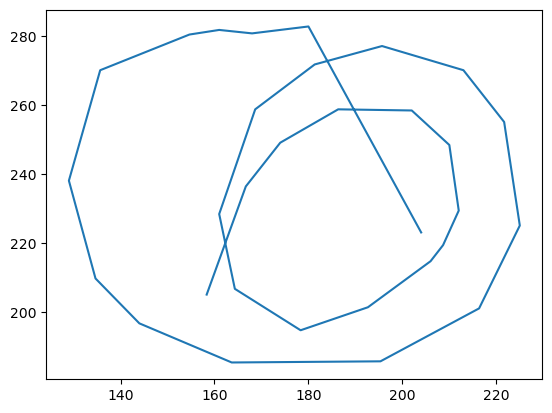

In [20]:
def preprocess_stroke(stroke: Iterable[ReplayEventOsu]):
    """
    Preprocess a stroke into a format suitable for spline interpolation.
    """
    positions = np.array([[event.x, event.y] for event in stroke])
    # repeat the ends of the stroke for spline to reach them
    positions = np.pad(positions, ((1,), (0,)), mode='edge')

    deltas = np.array([event.time_delta for event in stroke])
    # first delta of a stroke might be big or negative
    deltas[0] = 16
    # deltas might be too small and cause kinks in the spline
    # TODO: this might be problematic because key presses sometimes cause
    # valid small deltas, and this will make velocity hitch on streams
    deltas = np.maximum(deltas, 8)
    # repeat, same as with positions
    deltas = np.pad(deltas, (1), mode='edge')
    # 0 to make cumsum start from 0
    deltas[0] = 0

    timings = np.cumsum(deltas)
    return timings, positions

timings, sample = preprocess_stroke(split_example[3])
plt.plot(sample[:,0], sample[:,1])
timings, sample

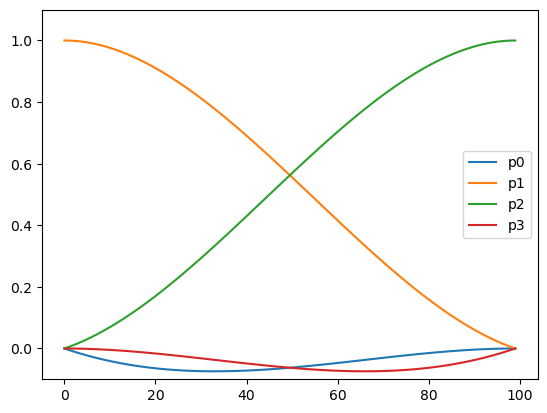

In [21]:
def cubic_barry_goldman_weights(knots, t):
    # original:
    # b1 = (knots[2] - t) / (knots[2] - knots[1])
    # b2 = (t - knots[1]) / (knots[2] - knots[1])

    # a1 = b1 * (knots[2] - t) / (knots[2] - knots[0])
    # a2 = b1 * (t - knots[0]) / (knots[2] - knots[0]) + b2 * (knots[3] - t) / (knots[3] - knots[1])
    # a3 = b2 * (t - knots[1]) / (knots[3] - knots[1])

    # p0 = a1 * (knots[1] - t) / (knots[1] - knots[0])
    # p1 = a1 * (t - knots[0]) / (knots[1] - knots[0]) + a2 * (knots[2] - t) / (knots[2] - knots[1])
    # p2 = a2 * (t - knots[1]) / (knots[2] - knots[1]) + a3 * (knots[3] - t) / (knots[3] - knots[2])
    # p3 = a3 * (t - knots[2]) / (knots[3] - knots[2])

    knots10 = knots[1] - knots[0]
    knots21 = knots[2] - knots[1]
    knots32 = knots[3] - knots[2]

    knots20 = knots[2] - knots[0]
    knots31 = knots[3] - knots[1]

    knots0t = knots[0] - t
    knots1t = knots[1] - t
    knots2t = knots[2] - t
    knots3t = knots[3] - t

    b1 = knots2t / knots21
    b2 = - knots1t / knots21

    a1 = b1 * knots2t / knots20
    a2 = b2 * knots3t / knots31 - b1 * knots0t / knots20 
    a3 = - b2 * knots1t / knots31

    p0 = a1 * knots1t / knots10
    p1 = a2 * knots2t / knots21 - a1 * knots0t / knots10
    p2 = a3 * knots3t / knots32 - a2 * knots1t / knots21
    p3 = - a3 * knots2t / knots32

    return np.array([p0, p1, p2, p3])

# Quick test
w = cubic_barry_goldman_weights(np.linspace(0, 3, 4), np.linspace(1, 2, 100))
plt.plot(w.T)
plt.legend(['p0', 'p1', 'p2', 'p3'])
plt.ylim(-0.1, 1.1);

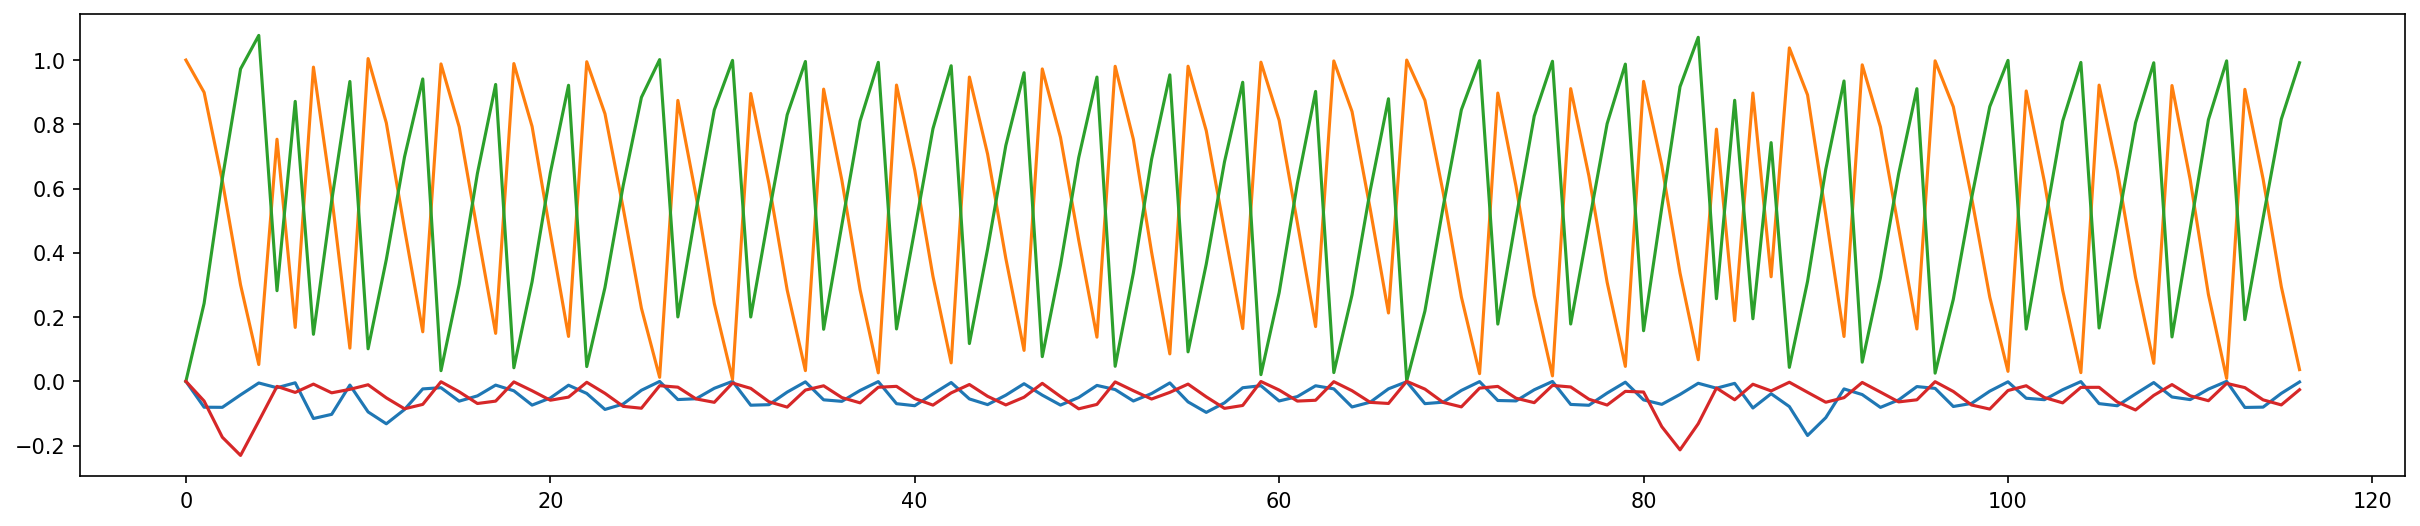

In [22]:
start, end = timings[1], timings[-2]-1
rate = 250
num_points = int((end - start) * rate / 1000)

t_interp = np.linspace(start, end, num_points)
# t_interp = np.linspace(timings[1], timings[-2]-1, int(timings[-2]/6))
t_ind = np.searchsorted(timings, t_interp, 'right').astype(int)
knots_interp = np.take(timings, [t_ind-2, t_ind-1, t_ind, t_ind+1], axis=0, mode='clip')
knot_weights = cubic_barry_goldman_weights(knots_interp, t_interp)
plt.figure(figsize=(20,4), dpi=150)
plt.plot(knot_weights.T);

((4, 117, 2), (4, 117), (117, 2))

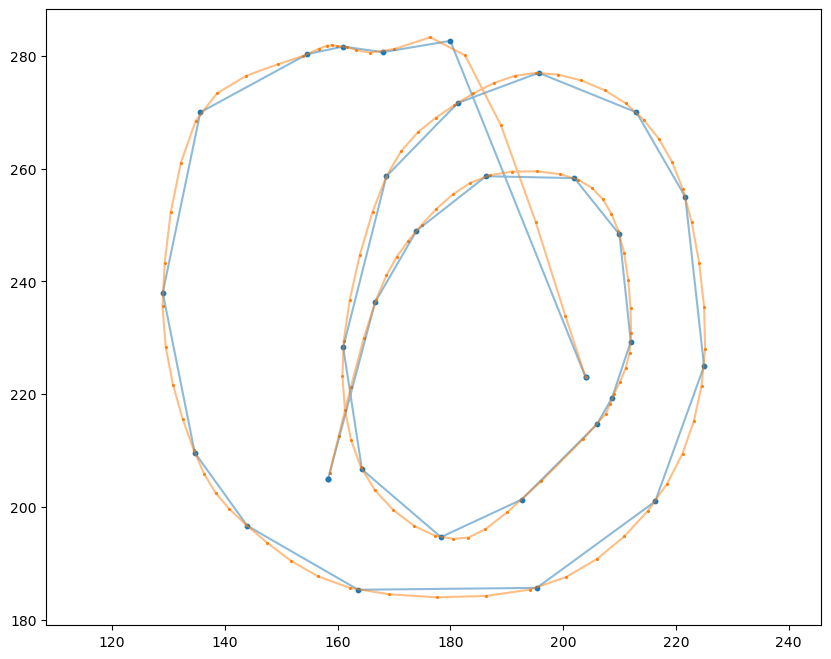

In [23]:
knot_positions = np.take(sample, [t_ind-2, t_ind-1, t_ind, t_ind+1], axis=0)
interp_positions = np.sum(knot_positions * knot_weights[:, :, None], axis=0)

plt.figure(figsize=(10, 8), dpi=100)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.plot(sample[:,0], sample[:,1], alpha=0.5)
plt.plot(interp_positions[:,0], interp_positions[:,1], alpha=0.5)
plt.scatter(sample[:,0], sample[:,1], s=10)
plt.scatter(interp_positions[:,0], interp_positions[:,1], s=1.5);

knot_positions.shape, knot_weights.shape, interp_positions.shape

In [24]:
def sample_stroke(timings, positions, rate, offset=0):
    start, end = timings[1] + offset, timings[-2] - 1
    num_points = int((end - start) * rate / 1000)
    t_interp = np.linspace(start, end, num_points)
    t_ind = np.searchsorted(timings, t_interp, 'right').astype(int)
    knots_interp = np.take(timings, [t_ind-2, t_ind-1, t_ind, t_ind+1], axis=0, mode='clip')
    knot_weights = cubic_barry_goldman_weights(knots_interp, t_interp)
    knot_positions = np.take(positions, [t_ind-2, t_ind-1, t_ind, t_ind+1], axis=0)
    interp_positions = np.sum(knot_positions * knot_weights[:, :, None], axis=0)
    return interp_positions

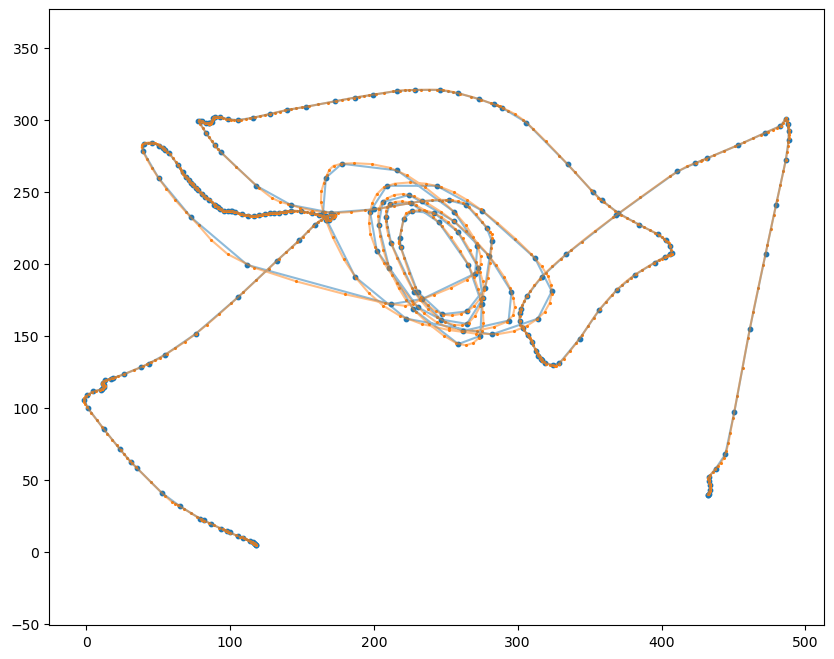

In [25]:
split_example_filename = "Replays/AbstractQbit - DECO27 - First Storm -Japanese Version- [Confidence] (2021-11-07) Osu.osr"
strokes = get_stroke_splits(list(collapse_stationary(fix_time_deltas(read_replay_data(split_example_filename)))))
timings, sample = preprocess_stroke(strokes[4])
resample = sample_stroke(timings, sample, 200)

plt.figure(figsize=(10, 8), dpi=100)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.plot(sample[:,0], sample[:,1], alpha=0.5)
plt.plot(resample[:,0], resample[:,1], alpha=0.5)
plt.scatter(sample[:,0], sample[:,1], s=10)
plt.scatter(resample[:,0], resample[:,1], s=1.5);

In [ ]:
strokes

## Getting strokes from multiple replays

In [54]:
# replays = itertools.islice(get_replays_from_folder(folder_path), 1000)
replays = [list(collapse_stationary(fix_time_deltas(replay.replay_data)))
           for replay in tqdm(get_replays_from_folder("Replays/"))]

strokes = []
for replay in replays:
    strokes += get_stroke_splits(replay, delta_threshold=50)

# strokes = filter(lambda stroke: len(stroke) > 15, strokes)
strokes = filter(lambda stroke: 15 < len(stroke) < 2048, strokes)
strokes = [preprocess_stroke(stroke) for stroke in strokes]
len(strokes), pd.Series([len(stroke[0]) for stroke in strokes]).quantile(np.arange(0, 1.1, 0.1))

105it [00:12,  8.24it/s]


(1510,
 0.0      18.0
 0.1      27.0
 0.2      37.8
 0.3      53.0
 0.4      74.0
 0.5     102.0
 0.6     160.4
 0.7     265.3
 0.8     508.8
 0.9    1000.1
 1.0    2033.0
 dtype: float64)

In [55]:
# replays_all = [list(collapse_stationary(fix_time_deltas(replay.replay_data)))
#            for replay in tqdm(get_replays_from_folder("H:/osu!/Data/r/"))]

# strokes_all = []
# for replay in tqdm(replays_all):
#     strokes_all += get_stroke_splits(replay, delta_threshold=50)
# strokes_all = filter(lambda stroke: len(stroke) > 15, strokes_all)
# strokes_all = [preprocess_stroke(stroke) for stroke in tqdm(strokes_all)]
# len(strokes_all), pd.Series([len(stroke[0]) for stroke in strokes_all]).quantile(np.arange(0, 1.1, 0.1))

In [56]:
replays_all = [list(collapse_stationary(fix_time_deltas(replay.replay_data)))
           for replay in tqdm(get_replays_from_folder("H:/osu!/Data/r/"))]

strokes_all = []
for replay in tqdm(replays_all):
    strokes_all += get_stroke_splits(replay, delta_threshold=50)
strokes_all = filter(lambda stroke: 15 < len(stroke) < 2048, strokes_all)
strokes_all = [preprocess_stroke(stroke) for stroke in tqdm(strokes_all)]


len(strokes_all), pd.Series([len(stroke[0]) for stroke in strokes_all]).quantile(np.arange(0, 1.1, 0.1))

7696it [08:31, 15.04it/s]
100%|██████████| 7696/7696 [00:08<00:00, 911.09it/s] 
77833it [00:20, 3881.96it/s]


(77833,
 0.0      18.0
 0.1      24.0
 0.2      33.0
 0.3      47.0
 0.4      68.0
 0.5     101.0
 0.6     164.0
 0.7     294.0
 0.8     549.0
 0.9    1049.0
 1.0    2049.0
 dtype: float64)

In [57]:
# subset_num = 64
# subset = random.sample(strokes, subset_num)
# pd.Series([len(stroke[0]) for stroke in subset]).quantile(np.arange(0, 1.1, 0.1))

In [58]:
import bisect

max_len_bins = [64, 512, 2048, 2**20]
bins = [[] for _ in range(len(max_len_bins))]

for stroke in strokes:
    bin_index = bisect.bisect_right(max_len_bins, len(stroke[0]))
    bins[bin_index].append(stroke)


In [59]:
print([len(bin) for bin in bins])

[532, 676, 302, 0]


In [60]:
subset_num = 64
subset = random.sample(bins[1], subset_num)
pd.Series([len(stroke[0]) for stroke in subset]).quantile(np.arange(0, 1.1, 0.1))

0.0     64.0
0.1     71.0
0.2     79.2
0.3     85.0
0.4    110.4
0.5    159.0
0.6    171.6
0.7    218.8
0.8    289.2
0.9    319.5
1.0    492.0
dtype: float64

In [119]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250)):
        self.rate_range = rate_range

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()
    

transforms = [
    StrokeResample(),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

# ds1 = StrokeDataset(bins[2], transforms=transforms)
# ds1 = StrokeDataset(strokes, transforms=transforms)
ds1 = StrokeDataset(strokes_all, transforms=transforms)

def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)

ds1loader = DataLoader(ds1, batch_size=256, shuffle=True, collate_fn=collate_pad_beginning_zeroes)


In [75]:
class ConvNetTest1(nn.Module):
    def __init__(self, kernels=[5, 5, 5, 3, 3], channels=[32, 32, 32, 16, 16]):
        super().__init__()
        # input is (batch, seq_len, 2)
        channels = [2] + channels
        self.convs = nn.ModuleList([nn.Conv1d(channels[i], channels[i+1], kernels[i]) for i in range(len(kernels))])
        self.out = nn.Linear(channels[-1], 2, bias=False)
        self.total_padding = sum(kernels) - len(kernels)

    def forward(self, x):
        x = x.transpose(1, 2) # (batch, 2, seq_len)
        for conv in self.convs:
            x = conv(x)
            x = F.silu(x)
        x = x.transpose(1, 2)
        x = self.out(x)
        x = F.pad(x, (0, 0, self.total_padding, 0))
        return x

# count parameters
sum(p.numel() for p in ConvNetTest1().parameters() if p.requires_grad)

13024

In [67]:
n_epochs = 30

model = ConvNetTest1().cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.000001)

losses = []

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in ds1loader:
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()

        # Forward pass
        outputs = model(batch[:, :-1, :])

        # Compute loss
        loss = F.huber_loss(outputs, batch[:, 1:, :])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

# plt.plot(losses)
# plt.yscale('log')


Epoch 1, Loss: 0.3436037600040436, LR: 0.0005
Epoch 2, Loss: 0.36427591492732364, LR: 0.0004986332128943842
Epoch 3, Loss: 0.3716975847880046, LR: 0.0004945478263830845
Epoch 4, Loss: 0.3273333013057709, LR: 0.0004877886008156408
Epoch 5, Loss: 0.33940023307998973, LR: 0.00047842959168182885
Epoch 6, Loss: 0.299451045691967, LR: 0.0004665733382442175
Epoch 7, Loss: 0.29743510857224464, LR: 0.0004523497400965494
Epoch 8, Loss: 0.2916483407219251, LR: 0.0004359146339566099
Epoch 9, Loss: 0.27865196391940117, LR: 0.00041744808628653516
Epoch 10, Loss: 0.25494953120748204, LR: 0.00039715242044697206
Epoch 11, Loss: 0.2618013781805833, LR: 0.00037525000000000004
Epoch 12, Loss: 0.23266374071439108, LR: 0.00035198079244741227
Epoch 13, Loss: 0.22823964431881905, LR: 0.00032759974009654945
Epoch 14, Loss: 0.20500367631514868, LR: 0.000302373966859031
Epoch 15, Loss: 0.20426623274882635, LR: 0.0002765798515852796
Epoch 16, Loss: 0.22190988063812256, LR: 0.0002505000000000001
Epoch 17, Loss: 0.

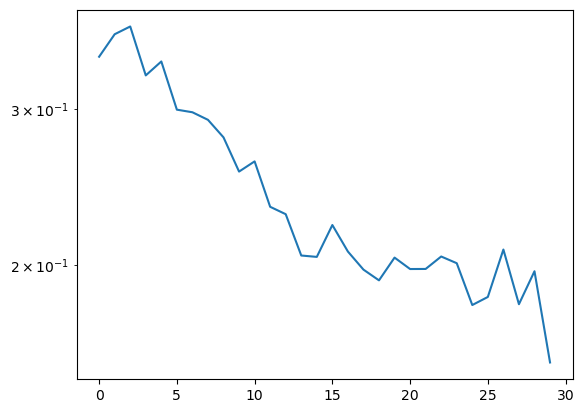

In [68]:
plt.plot(losses)
plt.yscale('log')

In [116]:
class TestNet2(nn.Module):
    def __init__(self, kernels=[5]*12, channels=[8]*4+[4]*4+[2]*4):
        # input is (batch, seq_len, 2)
        super().__init__()
        # let's organize channels in a densenet style thingy
        # also use glu activations, because why not, lol
        channels = [2] + channels + [2]
        in_channels = []
        for i in range(len(channels)):
            in_channels.append(sum(channels[:i]))
        
        channels = channels[1:]
        in_channels = in_channels[1:]
        kernels = kernels + [1]
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels[i], channels[i]*2, kernels[i]) for i in range(len(kernels))
        ])
        self.pads = [kernel - 1 for kernel in kernels]
    
    def forward(self, x):
        x = x.transpose(1, 2) # (batch, 2, seq_len)
        acts = [x]
        for i, conv in enumerate(self.convs):
            x = conv(torch.cat(acts, dim=1))
            x = F.glu(x, dim=1)
            x = F.pad(x, (self.pads[i], 0))
            acts.append(x)
        x = x.transpose(1, 2)
        return x

sum(p.numel() for p in TestNet2().parameters() if p.requires_grad)

15468

Epoch 1, Loss: 0.11588851490714511, LR: 0.002
Epoch 2, Loss: 0.09381912086830764, LR: 0.0019513012337136779
Epoch 3, Loss: 0.09461181367762753, LR: 0.0018099719094030727
Epoch 4, Loss: 0.09063033108584216, LR: 0.0015898463260310108
Epoch 5, Loss: 0.09103769607475547, LR: 0.0013124719094030728
Epoch 6, Loss: 0.0880367843709031, LR: 0.001005
Epoch 7, Loss: 0.08757416079523134, LR: 0.0006975280905969274
Epoch 8, Loss: 0.08635738391856679, LR: 0.0004201536739689894
Epoch 9, Loss: 0.08662001700674901, LR: 0.0002000280905969274
Epoch 10, Loss: 0.08816789696451094, LR: 5.869876628632224e-05


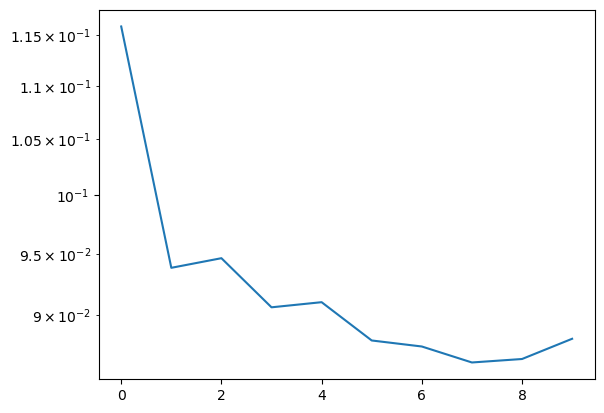

In [120]:
n_epochs = 10

model = TestNet2().cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.00001)

losses = []

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch in ds1loader:
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()

        # Forward pass
        outputs = model(batch[:, :-1, :])

        # Compute loss
        loss = F.huber_loss(outputs, batch[:, 1:, :])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

plt.plot(losses)
plt.yscale('log')

In [118]:
import gc
gc.collect()
torch.cuda.empty_cache()

I need to come up with some way to evaluate these networks and go on with a new notebook, this one is getting kinda messy.